# Graph Neural Network

In [1]:
import pandas as pd
import numpy as np
from rdflib import Graph, Namespace, URIRef, Literal
from rdflib.namespace import RDF, RDFS, OWL, XSD
import os

from torch_geometric.data import Data
import torch
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from torch_geometric.utils import subgraph
from rdflib.namespace import XSD
from sklearn.preprocessing import StandardScaler
import random
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from torch_geometric.data import Batch

In [2]:
os.getcwd()

'c:\\mahmoud uni\\TU\\SS2024\\KGs\\Portfolio'

## Load Knowledge Graph

In [3]:
BASE = Namespace("http://www.semanticweb.org/mabsa/ontologies/2024/10/ea-fc-ontology/")
g = Graph()
ontology_file = r"dataset\EA_FC_knowledge_graph.ttl" 
g.parse(ontology_file, format="ttl")

<Graph identifier=N74f92b6743ce466f97cce3c92ae2c9fc (<class 'rdflib.graph.Graph'>)>

In [4]:
# count all triples
print(f"Total triples: {len(g)}")

# class membership
player_count = len(list(g.subjects(RDF.type, BASE.Player)))
print(f"Total Players: {player_count}")

team_count = len(list(g.subjects(RDF.type, BASE.Club)))
print(f"Total Teams: {team_count}")

league_count = len(list(g.subjects(RDF.type, BASE.League)))
print(f"Total Leagues: {league_count}")

Total triples: 369646
Total Players: 6276
Total Teams: 2041
Total Leagues: 169


## Data Preperation

### Node Extraction

In [5]:
players = list(g.subjects(RDF.type, BASE.Player))
clubs = list(g.subjects(RDF.type, BASE.Club))
leagues = list(g.subjects(RDF.type, BASE.League))

# node index mapping
node_list = players + clubs + leagues
node_to_idx = {node: idx for idx, node in enumerate(node_list)}

In [6]:
position_encoder = LabelEncoder()
foot_encoder = LabelEncoder()
work_rate_encoder = LabelEncoder()
body_type_encoder = LabelEncoder()
league_encoder = LabelEncoder()
nationality_encoder = LabelEncoder()

positions = set()
preferred_feet = set()
work_rate_components = set()
body_types = set()
league_names = set()
nationalities = set()

for player in players:
    for p, o in g.predicate_objects(player):
        if p == BASE.position_category:
            positions.add(str(o))
        if p == BASE.preferred_foot:
            preferred_feet.add(str(o))
        if p == BASE.work_rate:
            work_rate = str(o)
            work_rate_att, work_rate_def = work_rate.split('/')
            work_rate_components.add(work_rate_att)
            work_rate_components.add(work_rate_def)
        if p == BASE.body_type:
            body_types.add(str(o))

for club in clubs:
    for p, o in g.predicate_objects(club):
        if p == BASE.name:
            league_names.add(str(o))

for league in leagues:
    for p, o in g.predicate_objects(league):
        if p == BASE.league_nationality_name:
            nationalities.add(str(o))

position_encoder.fit(list(positions))
foot_encoder.fit(list(preferred_feet))
work_rate_encoder.fit(list(work_rate_components)) 
body_type_encoder.fit(list(body_types))
league_encoder.fit(list(league_names))
nationality_encoder.fit(list(nationalities))


LabelEncoder()

### Feature Extraction

In [7]:
features = []
targets = []

for node in node_list:
    attrs = {}
    for p, o in g.predicate_objects(node):
        if isinstance(o, Literal):
            if o.datatype in [XSD.integer, XSD.float, XSD.double]:  # Numeric DataTypes 
                attrs[p.split("/")[-1]] = float(o)
            elif o.datatype in [XSD.string, None]:  # Categorical/String
                key = p.split("/")[-1]
                if key != 'name' and key != 'player_id':
                    attrs[key] = str(o)

    # Encode Categorical Features
    position_encoded = position_encoder.transform([attrs.get('position_category', 'DEF')])[0] if 'position_category' in attrs else 0
    preferred_foot_encoded = foot_encoder.transform([attrs.get('preferred_foot', 'Right')])[0] if 'preferred_foot' in attrs else 0
    body_type_encoded = body_type_encoder.transform([attrs.get('body_type', 'Normal')])[0] if 'body_type' in attrs else 0
    league_encoded = league_encoder.transform([attrs.get('name', 'Unknown')])[0] if 'name' in attrs else 0
    nationality_encoded = nationality_encoder.transform([attrs.get('league_nationality_name', 'Unknown')])[0] if 'league_nationality_name' in attrs else 0

    # Handle work_rate
    work_rate_att, work_rate_def = attrs.get('work_rate', 'Medium/Medium').split('/') if 'work_rate' in attrs else ('Medium', 'Medium')
    work_rate_att_encoded = work_rate_encoder.transform([work_rate_att])[0]
    work_rate_def_encoded = work_rate_encoder.transform([work_rate_def])[0]

    # Numeric Features
    numeric_features = [v for k, v in attrs.items() if isinstance(v, float) and k != 'name' and k != 'player_id'] 

    feature_vector = numeric_features + [
        position_encoded, 
        preferred_foot_encoded, 
        work_rate_att_encoded, 
        work_rate_def_encoded, 
        body_type_encoded,
        league_encoded,
        nationality_encoded
    ]

    potential = attrs.get('potential', None)

    features.append(feature_vector)
    targets.append(potential if potential is not None else 0)

# Padding
max_len = max(len(f) for f in features)
features = [f + [0] * (max_len - len(f)) for f in features]

In [8]:
# # Debugging
# sample = leagues[0]
# for p, o in g.predicate_objects(sample):
#     print(f"Predicate: {p}, Object: {o}, Data Type: {type(o)}, RDF DataType: {getattr(o, 'datatype', None)}")

### Edge Index

In [9]:
edge_index = []

for s, p, o in g:
    if s in node_to_idx and o in node_to_idx:
        edge_index.append([node_to_idx[s], node_to_idx[o]])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

### Train-Test-Val Split

#### Random Split

In [10]:
seed = 1120
np.random.seed(seed)
torch.manual_seed(seed)

num_nodes = len(node_list)
indices = np.random.permutation(num_nodes) # shuffle

train_cutoff_rand = int(0.6 * num_nodes)
val_cutoff_rand = int(0.8 * num_nodes)

train_indices_rand = indices[:train_cutoff_rand]
val_indices_rand = indices[train_cutoff_rand:val_cutoff_rand]
test_indices_rand = indices[val_cutoff_rand:]

train_mask_rand = torch.zeros(num_nodes, dtype=torch.bool)
val_mask_rand = torch.zeros(num_nodes, dtype=torch.bool)
test_mask_rand = torch.zeros(num_nodes, dtype=torch.bool)

train_mask_rand[train_indices_rand] = True
val_mask_rand[val_indices_rand] = True
test_mask_rand[test_indices_rand] = True

x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(targets, dtype=torch.float)

# PyG Data Object
data_rand = Data(x=x, edge_index=edge_index, y=y, 
                 train_mask=train_mask_rand, 
                 val_mask=val_mask_rand, 
                 test_mask=test_mask_rand)

# Standardize
data_rand.x = torch.tensor(StandardScaler().fit_transform(data_rand.x), dtype=torch.float)
data_rand

Data(x=[8486, 52], edge_index=[2, 16394], y=[8486], train_mask=[8486], val_mask=[8486], test_mask=[8486])

#### Stratfied Split

In [11]:
seed = 1120
np.random.seed(seed)
torch.manual_seed(seed)

unique_player_ids = set()
player_id_to_indices = {}

for idx, node in enumerate(players):
    for p, o in g.predicate_objects(node):
        if p == BASE.player_id:
            player_id_full = str(o)
            player_unique_id = player_id_full.split('_')[0]
            unique_player_ids.add(player_unique_id)

            # Map unique player ID to indices in node_list
            if player_unique_id not in player_id_to_indices:
                player_id_to_indices[player_unique_id] = []
            player_id_to_indices[player_unique_id].append(idx)

# shuffle and split player IDs
unique_player_ids = list(unique_player_ids)
np.random.shuffle(unique_player_ids)

num_players = len(unique_player_ids)
train_cutoff = int(0.6 * num_players)
val_cutoff = int(0.8 * num_players)

train_ids = unique_player_ids[:train_cutoff]
val_ids = unique_player_ids[train_cutoff:val_cutoff]
test_ids = unique_player_ids[val_cutoff:]

train_mask = torch.zeros(len(node_list), dtype=torch.bool)
val_mask = torch.zeros(len(node_list), dtype=torch.bool)
test_mask = torch.zeros(len(node_list), dtype=torch.bool)  

for player_id in train_ids:
    for idx in player_id_to_indices[player_id]:
        train_mask[idx] = True

for player_id in val_ids:
    for idx in player_id_to_indices[player_id]:
        val_mask[idx] = True

for player_id in test_ids:
    for idx in player_id_to_indices[player_id]:
        test_mask[idx] = True


x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(targets, dtype=torch.float)
data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
data.x = torch.tensor(StandardScaler().fit_transform(data.x), dtype=torch.float)

print(data)

print(f"Total nodes: {data.num_nodes}")
print(f"Player nodes: {len(players)}, Club nodes: {len(clubs)}, League nodes: {len(leagues)}")

Data(x=[8486, 52], edge_index=[2, 16394], y=[8486], train_mask=[8486], val_mask=[8486], test_mask=[8486])
Total nodes: 8486
Player nodes: 6276, Club nodes: 2041, League nodes: 169


In [12]:
train_players = set(train_ids)
val_players = set(val_ids)
test_players = set(test_ids)

overlap_train_val = train_players.intersection(val_players)
overlap_train_test = train_players.intersection(test_players)
overlap_val_test = val_players.intersection(test_players)

print("Validation Results:")
print(f"Overlap between Train and Validation: {len(overlap_train_val)}")
print(f"Overlap between Train and Test: {len(overlap_train_test)}")
print(f"Overlap between Validation and Test: {len(overlap_val_test)}")

assert len(overlap_train_val) == 0, "Overlap detected between Train and Validation sets!"
assert len(overlap_train_test) == 0, "Overlap detected between Train and Test sets!"
assert len(overlap_val_test) == 0, "Overlap detected between Validation and Test sets!"

# proportion
total_players = len(train_players) + len(val_players) + len(test_players)
print("\nProportion of each split:")
print(f"Train Set: {len(train_players)} players ({(len(train_players)/total_players)*100:.2f}%)")
print(f"Validation Set: {len(val_players)} players ({(len(val_players)/total_players)*100:.2f}%)")
print(f"Test Set: {len(test_players)} players ({(len(test_players)/total_players)*100:.2f}%)")

print("\nNo overlaps detected. The split is valid.")

Validation Results:
Overlap between Train and Validation: 0
Overlap between Train and Test: 0
Overlap between Validation and Test: 0

Proportion of each split:
Train Set: 941 players (59.97%)
Validation Set: 314 players (20.01%)
Test Set: 314 players (20.01%)

No overlaps detected. The split is valid.


### Define Data Loaders

In [13]:
def create_subgraph(data, mask):
    """Creates a subgraph containing only the nodes from the given mask."""
    node_indices = mask.nonzero(as_tuple=True)[0]  # Get the indices of nodes in this split
    edge_index, _ = subgraph(node_indices, data.edge_index, relabel_nodes=True)  # Extract subgraph edges

    return Data(
        x=data.x[node_indices],  # Features of selected nodes
        edge_index=edge_index,   # Only edges within this subset
        y=data.y[node_indices],  # Target labels for these nodes
    )

batch_size = 64

In [14]:
torch.manual_seed(1120)

train_data_rand = create_subgraph(data_rand, data_rand.train_mask)
val_data_rand = create_subgraph(data_rand, data_rand.val_mask)
test_data_rand = create_subgraph(data_rand, data_rand.test_mask)


# train_loader_rand = DataLoader(
#     [train_data_rand], batch_size=batch_size, shuffle=True,
#     num_workers=0,
#     worker_init_fn=lambda worker_id: np.random.seed(1120),  
#     generator=torch.Generator().manual_seed(1120)
# )

# val_loader_rand = DataLoader(
#     [val_data_rand], batch_size=batch_size, shuffle=False,
#     num_workers=0,
#     worker_init_fn=lambda worker_id: np.random.seed(1120),
#     generator=torch.Generator().manual_seed(1120)
# )

# test_loader_rand = DataLoader(
#     [test_data_rand], batch_size=batch_size, shuffle=False,
#     num_workers=0,
#     worker_init_fn=lambda worker_id: np.random.seed(1120),
#     generator=torch.Generator().manual_seed(1120)
# )


train_loader_rand = DataLoader([train_data_rand], batch_size=batch_size, shuffle=True)
val_loader_rand = DataLoader([val_data_rand], batch_size=batch_size, shuffle=False)
test_loader_rand = DataLoader([test_data_rand], batch_size=batch_size, shuffle=False)


In [15]:
torch.manual_seed(1120)

train_data = create_subgraph(data, data.train_mask)
val_data = create_subgraph(data, data.val_mask)
test_data = create_subgraph(data, data.test_mask)

# train_loader = DataLoader(
#     [train_data], batch_size=batch_size, shuffle=True,
#     num_workers=0,
#     worker_init_fn=lambda worker_id: np.random.seed(1120),  
#     generator=torch.Generator().manual_seed(1120) 
# )

# val_loader = DataLoader(
#     [val_data], batch_size=batch_size, shuffle=False,
#     num_workers=0,
#     worker_init_fn=lambda worker_id: np.random.seed(1120),
#     generator=torch.Generator().manual_seed(1120)
# )

# test_loader = DataLoader(
#     [test_data], batch_size=batch_size, shuffle=False,
#     num_workers=0,
#     worker_init_fn=lambda worker_id: np.random.seed(1120),
#     generator=torch.Generator().manual_seed(1120)
# )

# there are some issues with the seed but the 

train_loader = DataLoader([train_data], batch_size=batch_size, shuffle=True)
val_loader = DataLoader([val_data], batch_size=batch_size, shuffle=False)
test_loader = DataLoader([test_data], batch_size=batch_size, shuffle=False)

Note: There is an issue with setting the seed for the Dataloader, multiple approaches failed! The results below are consistent for all approaches!

## Model Preperation

In [16]:
def set_seed(seed=1120):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, batch):
        x, edge_index = batch.x, batch.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        out = self.fc(x) 
        return out.view(-1) 


def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for batch in loader:
        batch = batch.to(next(model.parameters()).device)

        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)



def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_mae, total_rmse, total_r2 = 0, 0, 0, 0

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(next(model.parameters()).device)

            out = model(batch)

            loss = criterion(out, batch.y.view(-1))
            mae = F.l1_loss(out, batch.y.view(-1)).item()
            rmse = torch.sqrt(F.mse_loss(out, batch.y.view(-1))).item()

            ss_res = torch.sum((batch.y - out) ** 2)
            ss_tot = torch.sum((batch.y - torch.mean(batch.y)) ** 2)
            r2 = 1 - ss_res / ss_tot

            total_loss += loss.item()
            total_mae += mae
            total_rmse += rmse
            total_r2 += r2.item()

    num_batches = len(loader)
    return (total_loss / num_batches, total_mae / num_batches,
            total_rmse / num_batches, total_r2 / num_batches)


## Random Split Model Implementation

In [17]:
input_dim_rand = data_rand.x.shape[1]  
hidden_dim_rand = 32

set_seed(1120)
model_rand = GNN(input_dim_rand, hidden_dim_rand)
optimizer_rand = torch.optim.Adam(model_rand.parameters(), lr=0.001, weight_decay=1e-3)
scheduler_rand = StepLR(optimizer_rand, step_size=1000, gamma=0.8)
criterion_rand = nn.MSELoss()

num_epochs_rand = 10000
best_val_loss_rand = float("inf")
patience_rand = 500
counter_rand = 0

for epoch in range(1, num_epochs_rand + 1):
    train_loss_rand = train(model_rand, train_loader_rand, optimizer_rand, criterion_rand)
    val_loss_rand, val_mae_rand, val_rmse_rand, val_r2_rand = evaluate(model_rand, val_loader_rand, criterion_rand)

    # Save best model
    if val_loss_rand < best_val_loss_rand:
        best_val_loss_rand = val_loss_rand
        best_model_rand = model_rand.state_dict()
        counter_rand = 0
    else:
        counter_rand += 1

    if counter_rand >= patience_rand:
        print(f"Early stopping at epoch {epoch}")
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss_rand:.4f} | Val Loss: {val_loss_rand:.4f} | Val MAE: {val_mae_rand:.4f} | Val RMSE: {val_rmse_rand:.4f} | Val R^2: {val_r2_rand:.4f}")
        break

    if epoch % 500 == 0:
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss_rand:.4f} | Val Loss: {val_loss_rand:.4f} | Val MAE: {val_mae_rand:.4f} | Val RMSE: {val_rmse_rand:.4f} | Val R^2: {val_r2_rand:.4f}")


Epoch 500 | Train Loss: 611.6086 | Val Loss: 382.7237 | Val MAE: 13.5051 | Val RMSE: 19.5633 | Val R^2: 0.6474
Epoch 1000 | Train Loss: 221.8494 | Val Loss: 125.4368 | Val MAE: 5.2314 | Val RMSE: 11.1999 | Val R^2: 0.8845
Epoch 1500 | Train Loss: 91.2385 | Val Loss: 64.4123 | Val MAE: 3.2902 | Val RMSE: 8.0257 | Val R^2: 0.9407
Epoch 2000 | Train Loss: 47.1020 | Val Loss: 47.9815 | Val MAE: 2.3243 | Val RMSE: 6.9269 | Val R^2: 0.9558
Epoch 2500 | Train Loss: 27.9020 | Val Loss: 45.8805 | Val MAE: 1.8970 | Val RMSE: 6.7735 | Val R^2: 0.9577
Epoch 3000 | Train Loss: 16.8890 | Val Loss: 43.4306 | Val MAE: 1.9398 | Val RMSE: 6.5902 | Val R^2: 0.9600
Epoch 3500 | Train Loss: 9.7618 | Val Loss: 38.0520 | Val MAE: 1.4397 | Val RMSE: 6.1686 | Val R^2: 0.9649
Epoch 4000 | Train Loss: 6.1916 | Val Loss: 38.9166 | Val MAE: 1.3753 | Val RMSE: 6.2383 | Val R^2: 0.9642
Early stopping at epoch 4059
Epoch 4059 | Train Loss: 5.9861 | Val Loss: 39.4158 | Val MAE: 1.4112 | Val RMSE: 6.2782 | Val R^2: 0.9

In [18]:
#save
model_path_rand = "models/best_model_rand.pth"
torch.save(best_model_rand, model_path_rand)
print(f"Model saved successfully at {model_path_rand}")

Model saved successfully at models/best_model_rand.pth


In [19]:
# eval on test set
model_rand.load_state_dict(best_model_rand)
test_loss_rand, test_mae_rand, test_rmse_rand, test_r2_rand = evaluate(model_rand, test_loader_rand, criterion_rand)
print(f"\nFinal Test Evaluation - Loss: {test_loss_rand:.4f} | MAE: {test_mae_rand:.4f} | RMSE: {test_rmse_rand:.4f} | R^2: {test_r2_rand:.4f}")


Final Test Evaluation - Loss: 30.2872 | MAE: 1.1837 | RMSE: 5.5034 | R^2: 0.9726


## Stratfied Split Model Implementation

In [20]:
input_dim = data.x.shape[1]  
#hidden_dim = 64
hidden_dim = 32

set_seed(1120)
model = GNN(input_dim, hidden_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = StepLR(optimizer, step_size=1000, gamma=0.8)
criterion = nn.MSELoss()
num_epochs = 10000
best_val_loss = float("inf")
patience = 500
counter = 0

for epoch in range(1, num_epochs + 1):
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss, val_mae, val_rmse, val_r2 = evaluate(model, val_loader, criterion)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model.state_dict()
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val MAE: {val_mae:.4f} | Val RMSE: {val_rmse:.4f} | Val R^2: {val_r2:.4f}")
        break

    if epoch % 500 == 0:
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val MAE: {val_mae:.4f} | Val RMSE: {val_rmse:.4f} | Val R^2: {val_r2:.4f}")



Epoch 500 | Train Loss: 11.1212 | Val Loss: 10.9100 | Val MAE: 2.6300 | Val RMSE: 3.3030 | Val R^2: 0.8292
Epoch 1000 | Train Loss: 3.1164 | Val Loss: 3.9431 | Val MAE: 1.5293 | Val RMSE: 1.9857 | Val R^2: 0.9383
Epoch 1500 | Train Loss: 1.2577 | Val Loss: 1.8922 | Val MAE: 1.0367 | Val RMSE: 1.3756 | Val R^2: 0.9704
Epoch 2000 | Train Loss: 0.5434 | Val Loss: 0.9252 | Val MAE: 0.6840 | Val RMSE: 0.9618 | Val R^2: 0.9855
Epoch 2500 | Train Loss: 0.3055 | Val Loss: 0.6167 | Val MAE: 0.4978 | Val RMSE: 0.7853 | Val R^2: 0.9903
Epoch 3000 | Train Loss: 0.2037 | Val Loss: 0.4968 | Val MAE: 0.4162 | Val RMSE: 0.7048 | Val R^2: 0.9922
Epoch 3500 | Train Loss: 0.1453 | Val Loss: 0.3919 | Val MAE: 0.3641 | Val RMSE: 0.6260 | Val R^2: 0.9939
Epoch 4000 | Train Loss: 0.0954 | Val Loss: 0.2787 | Val MAE: 0.3073 | Val RMSE: 0.5279 | Val R^2: 0.9956
Epoch 4500 | Train Loss: 0.0622 | Val Loss: 0.1944 | Val MAE: 0.2568 | Val RMSE: 0.4409 | Val R^2: 0.9970
Epoch 5000 | Train Loss: 0.0404 | Val Loss: 0

In [21]:
model_path = "models/best_model.pth"
torch.save(best_model, model_path)
print(f"Model saved successfully at {model_path}")

Model saved successfully at models/best_model.pth


In [22]:
# eval on test set
test_loss, test_mae, test_rmse, test_r2 = evaluate(model, test_loader, criterion)
print(f"\nFinal Test Evaluation - Loss: {test_loss:.4f} | MAE: {test_mae:.4f} | RMSE: {test_rmse:.4f} | R^2: {test_r2:.4f}")


Final Test Evaluation - Loss: 0.1284 | MAE: 0.1382 | RMSE: 0.3583 | R^2: 0.9980


## Evaluation

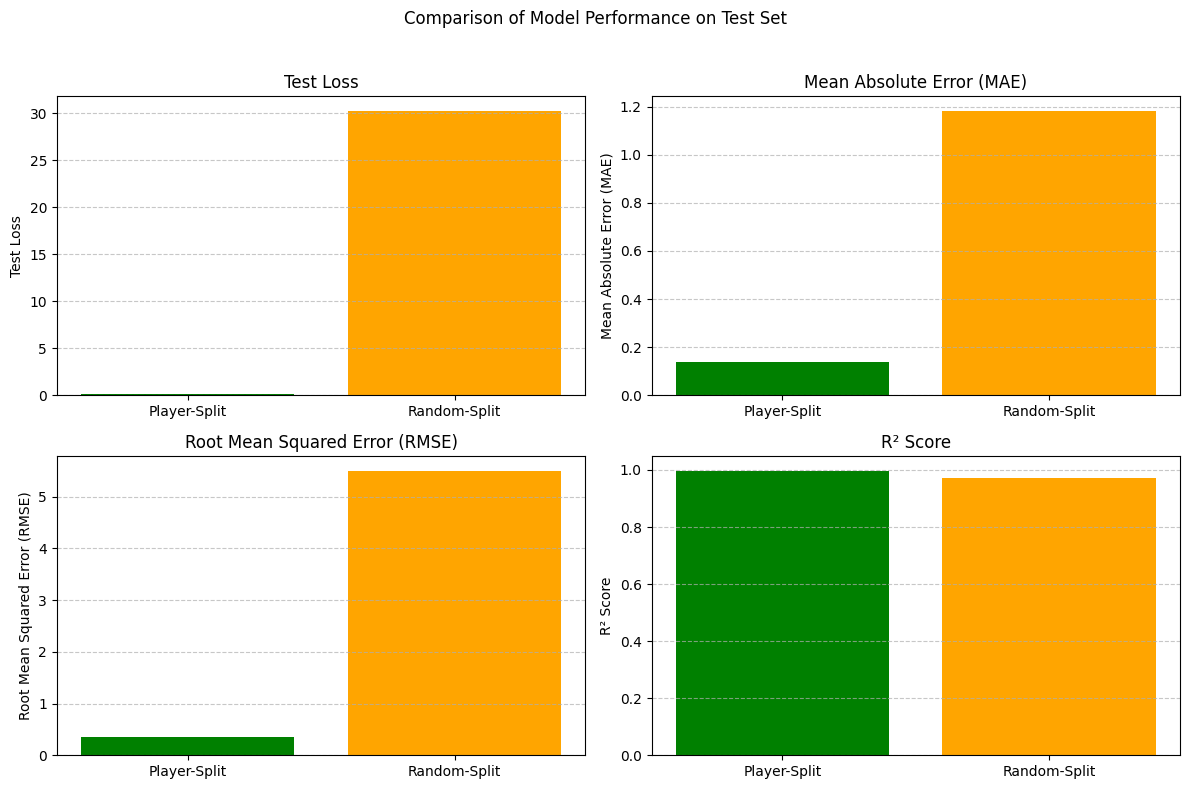

In [23]:
test_loss, test_mae, test_rmse, test_r2 = evaluate(model, test_loader, criterion)
test_loss_rand, test_mae_rand, test_rmse_rand, test_r2_rand = evaluate(model_rand, test_loader_rand, criterion_rand)

metrics = {
    "Test Loss": [test_loss, test_loss_rand],
    "Mean Absolute Error (MAE)": [test_mae, test_mae_rand],
    "Root Mean Squared Error (RMSE)": [test_rmse, test_rmse_rand],
    "R² Score": [test_r2, test_r2_rand]
}

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Comparison of Model Performance on Test Set")

for ax, (metric_name, values) in zip(axes.flat, metrics.items()):
    ax.bar(["Player-Split", "Random-Split"], values, color=["green", "orange"])
    ax.set_title(metric_name)
    ax.set_ylabel(metric_name)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()